In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [30]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from src.data_processor.phase_2.prob2.v2 import  Phase2Prob2FeatureProcessor
import numpy as np

In [31]:
df = pd.read_parquet("D:/Data/MLOPS_2023/data_phase-2/phase-2/prob-2/raw_train.parquet")
df['label'].value_counts()

Normal                   22390
Other                    13963
Exploits                 10864
Denial of Service         9585
Information Gathering     4081
Malware                    958
Name: label, dtype: int64

In [32]:
df.to_csv('output2.csv',index=False)

In [33]:
[x for x in df.columns if x not in categorical+['label']]

['feature1',
 'feature5',
 'feature6',
 'feature7',
 'feature8',
 'feature9',
 'feature10',
 'feature11',
 'feature12',
 'feature13',
 'feature14',
 'feature15',
 'feature16',
 'feature17',
 'feature18',
 'feature19',
 'feature20',
 'feature21',
 'feature22',
 'feature23',
 'feature24',
 'feature25',
 'feature26',
 'feature27',
 'feature28',
 'feature29',
 'feature30',
 'feature31',
 'feature32',
 'feature33',
 'feature34',
 'feature35',
 'feature36',
 'feature37',
 'feature38',
 'feature39',
 'feature40',
 'feature41']

In [34]:
df[['feature22','feature19']].corr()

,feature22,feature19
feature22,1.000000,0.980565
feature19,0.980565,1.000000


In [35]:
df[['feature9','feature27']].corr()

,feature9,feature27
feature9,1.00000,-0.54512
feature27,-0.54512,1.00000


In [36]:
df[['feature6','feature14']].corr()

,feature6,feature14
feature6,1.000000,0.981393
feature14,0.981393,1.000000


In [37]:
df[['feature5','feature7','feature13']].corr()

,feature5,feature7,feature13
feature5,1.000000,0.962818,0.970190
feature7,0.962818,1.000000,0.995964
feature13,0.970190,0.995964,1.000000


In [38]:
df[['feature30','feature35','feature40']].corr()

,feature30,feature35,feature40
feature30,1.000000,0.954055,0.978894
feature35,0.954055,1.000000,0.960421
feature40,0.978894,0.960421,1.000000


<Axes: >

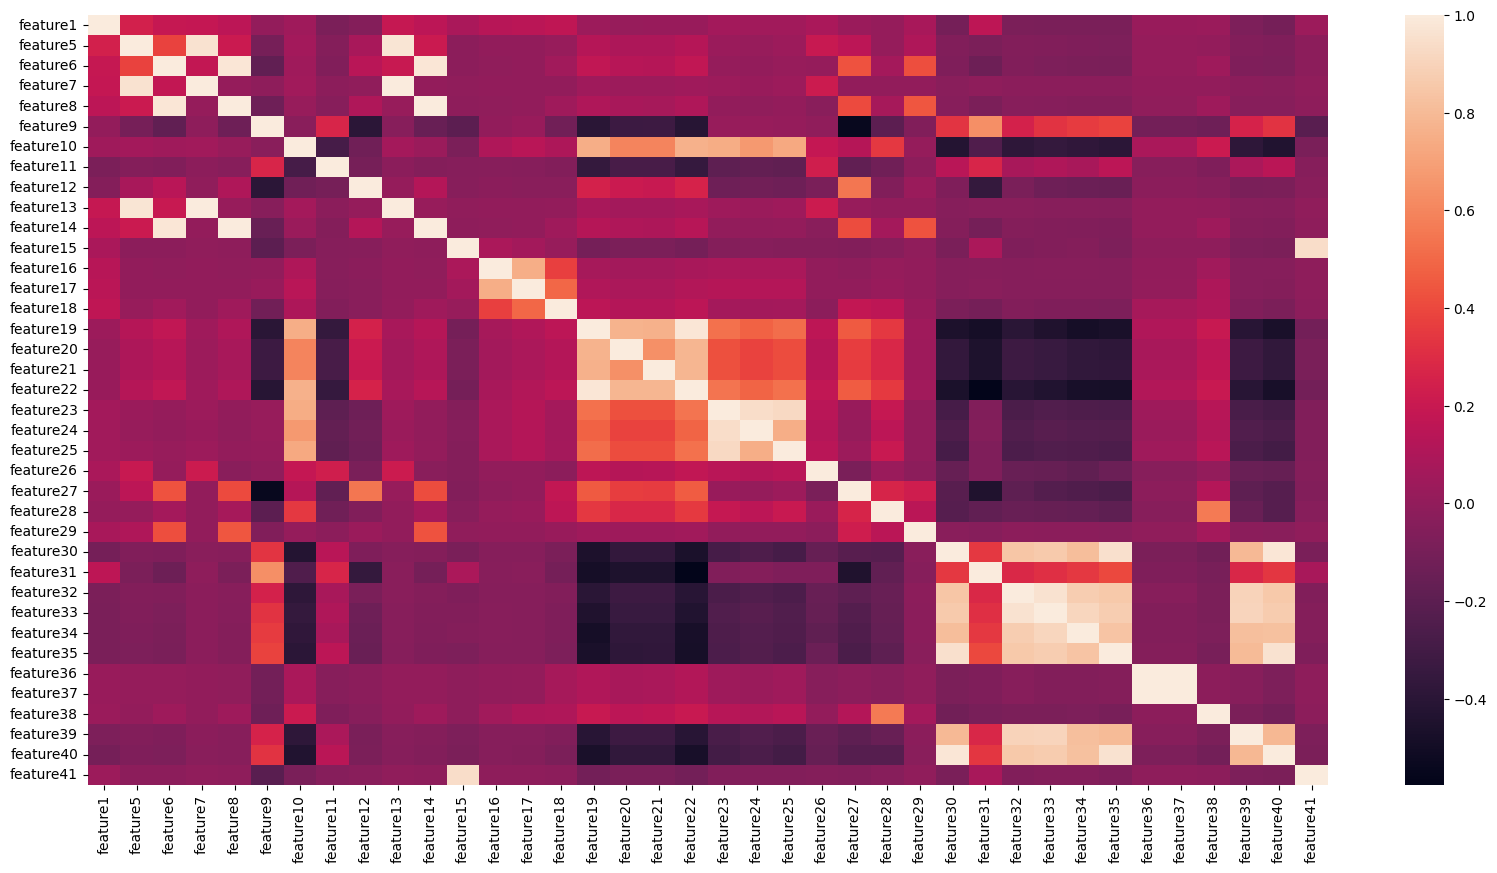

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sns.heatmap(df[[x for x in df.columns if x not in categorical+['label']]].corr())

In [40]:
# df.drop_duplicates(inplace=True)
# df['label'].value_counts()

In [41]:
df.reset_index(drop=True, inplace=True)
x = df.groupby(['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6',
                'feature7', 'feature8', 'feature9', 'feature10', 'feature11',
                'feature12', 'feature13', 'feature14', 'feature15', 'feature16',
                'feature17', 'feature18', 'feature19', 'feature20', 'feature21',
                'feature22', 'feature23', 'feature24', 'feature25', 'feature26',
                'feature27', 'feature28', 'feature29', 'feature30', 'feature31',
                'feature32', 'feature33', 'feature34', 'feature35', 'feature36',
                'feature37', 'feature38', 'feature39', 'feature40', 'feature41']).apply(lambda x : pd.Series({'list_index':list(x.index),'list_label':list(x['label'])})).reset_index()
a = x[x['list_label'].apply(lambda x: len(x)>1)]
blacklist = []
for t in a['list_index'].values:
    blacklist.extend(t)
    index = np.array(blacklist)
not_index = np.setdiff1d(df.index.to_numpy(), index)
new_df = df.iloc[not_index]
new_df.reset_index(inplace=True, drop=True)
# df['label'].value_counts()

In [42]:
new_df.shape

(37813, 42)

In [43]:
from collections import Counter

In [44]:
def max_label(x):
    if len(x) == 1:
        return x[0][0]
    if x[0][1] > x[1][1]:
        return x[0][0]
    return 'Unknown'
a['label'] = a['list_label'].apply(lambda x:max_label(Counter(x).most_common(2)))

In [45]:
new_2 = a[a['label']!='Unknown']

In [46]:
new_2.drop(columns=['list_index'],inplace=True)

In [47]:
df = pd.concat([new_df, new_2],axis=0)
df = df.sample(frac=1, random_state=42)

In [48]:
df['label'].value_counts()

Normal                   21492
Exploits                  7418
Denial of Service         6321
Other                     4740
Information Gathering     2388
Malware                    495
Name: label, dtype: int64

In [70]:
HyperParameters={'objective': 'multiclass',
                 'n_estimators':100,
                 'learning_rate':0.1,
                 'max_depth':11,
                 'colsample_bytree':0.5,
                 'subsample':0.8,
                 'reg_alpha':1.2,
                 'reg_lambda':10,
                 'random_state':42,
                 'min_child_samples':120,
                 'class_weight':{'Normal':1, 'Exploits':2,'Denial of Service':2,'Other':2, 'Information Gathering':2,'Malware':3 }
              }
hyper_parameters = HyperParameters.copy()

In [71]:
processor = Phase2Prob2FeatureProcessor()
new_df = processor.transform(df)

In [72]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
FEATURES = processor.data_features['features']
categorical = processor.data_features['categorical_features']
TARGET = 'label'

In [73]:
# def run(trial):
    
# #     num_leaves       = trial.suggest_int("num_leaves", 2, 40)
#     colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.2, 1.0)
#     subsample = trial.suggest_uniform("subsample", 0.2, 1.0)
#     reg_lambda        = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
#     reg_alpha        = trial.suggest_loguniform('lambda_l2', 1e-8, 10.0)
#     max_depth = trial.suggest_int('max_depth',3,10)
#     hyper_parameters['colsample_bytree'] = colsample_bytree
#     hyper_parameters['subsample'] = subsample
#     hyper_parameters['reg_lambda'] = reg_lambda
#     hyper_parameters['reg_alpha'] = reg_alpha
#     hyper_parameters['max_depth'] = max_depth

#     models = []
#     scores = []
#     oofs = np.empty(df.shape[0], dtype='object')
#     for i, (train_idx, valid_idx) in enumerate(kfold.split(new_df, df['label'])):
#         # Xy_train = new_df.iloc[train_idx]
#         # Xy_train['label'] = df.iloc[train_idx][TARGET]
#         # Xy_train_NORMAL = Xy_train[Xy_train.label.apply(lambda x: x == 'Malware')]
#         # Xy_train_NORMAL_sample = Xy_train_NORMAL.sample(frac=1, random_state=42)
#         # # print(Xy_train_NORMAL_sample['label'].value_counts())
#         # Xy_train_OTHER = Xy_train[Xy_train.label.apply(lambda x: x != 'Malware')]
#         # Xy_train_sample = pd.concat([Xy_train_OTHER,Xy_train_NORMAL_sample])
#         # Xy_train_sample = Xy_train_sample.sample(frac=1,random_state=123)
#         # print(Xy_train_sample['label'].value_counts())

#         X_train = new_df.iloc[train_idx]
#         y_train = df.iloc[train_idx][TARGET]
#         X_valid = new_df.iloc[valid_idx]
#         y_valid = df.iloc[valid_idx][TARGET]


#         print(X_train.shape, X_valid.shape)
#         print(y_train.shape, y_valid.shape)
#         model = LGBMClassifier(**hyper_parameters)
#         model.fit(X_train, y_train,
#                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
#                 eval_metric=["logloss"],
#                 categorical_feature=categorical,
#                 early_stopping_rounds=50,
#                 verbose=50)
#         # model = CatBoostClassifier(iterations=100, learning_rate=0.05, max_depth=7, subsample=0.8, random_state=42,eval_metric='AUC',class_weights={1:1.5,0:1})
#         # model.fit(X_train, y_train,
#         #           cat_features=categorical,
#         #           eval_set=[(X_train, y_train), (X_valid, y_valid)])
#         models.append(model)
#         y_pred = model.predict(X_valid)
#         oofs[valid_idx] = y_pred

#         print(f"fold {i} : {accuracy_score(y_valid, y_pred)}")
#         print(classification_report(y_valid, y_pred))
#         scores.append(accuracy_score(y_valid, y_pred))
#     error = 1- accuracy_score(df[TARGET], oofs)
#     print(np.mean(scores), np.std(scores))
#     print(classification_report(df[TARGET], oofs))
#     print(accuracy_score(df[TARGET], oofs))
#     return error

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
# study = optuna.create_study()  # Create a new study.
# study.optimize(run, n_trials=100)

In [75]:
hyper_parameters

{'objective': 'multiclass',
 'n_estimators': 100,
 'learning_rate': 0.1,
 'max_depth': 11,
 'colsample_bytree': 0.5,
 'subsample': 0.8,
 'reg_alpha': 1.2,
 'reg_lambda': 10,
 'random_state': 42,
 'min_child_samples': 120,
 'class_weight': {'Normal': 1,
  'Exploits': 2,
  'Denial of Service': 2,
  'Other': 2,
  'Information Gathering': 2,
  'Malware': 3}}

In [76]:
TARGET = 'label'
# hyper_parameters['objective'] = 'multiclass'
hyper_parameters['n_estimators'] = 1000
hyper_parameters['learning_rate'] = 0.03
hyper_parameters['class_weight'] = None
models = []
scores = []
oofs = np.empty(df.shape[0], dtype='object')
for i, (train_idx, valid_idx) in enumerate(kfold.split(new_df, df[TARGET])):
    # Xy_train = new_df.iloc[train_idx]
    # Xy_train['label'] = df.iloc[train_idx][TARGET]
    # Xy_train_NORMAL = Xy_train[Xy_train.label.apply(lambda x: x == 'Malware')]
    # Xy_train_NORMAL_sample = Xy_train_NORMAL.sample(frac=1, random_state=42)
    # # print(Xy_train_NORMAL_sample['label'].value_counts())
    # Xy_train_OTHER = Xy_train[Xy_train.label.apply(lambda x: x != 'Malware')]
    # Xy_train_sample = pd.concat([Xy_train_OTHER,Xy_train_NORMAL_sample])
    # Xy_train_sample = Xy_train_sample.sample(frac=1,random_state=123)
    # print(Xy_train_sample['label'].value_counts())

    X_train = new_df.iloc[train_idx]
    y_train = df.iloc[train_idx][TARGET]
    X_valid = new_df.iloc[valid_idx]
    y_valid = df.iloc[valid_idx][TARGET]


    print(X_train.shape, X_valid.shape)
    print(y_train.shape, y_valid.shape)
    model = LGBMClassifier(**hyper_parameters)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric=["logloss"],
              categorical_feature=categorical,
              early_stopping_rounds=50,
              verbose=50)
    # model = CatBoostClassifier(iterations=100, learning_rate=0.05, max_depth=7, subsample=0.8, random_state=42,eval_metric='AUC',class_weights={1:1.5,0:1})
    # model.fit(X_train, y_train,
    #           cat_features=categorical,
    #           eval_set=[(X_train, y_train), (X_valid, y_valid)])
    models.append(model)
    y_pred = model.predict(X_valid)
    oofs[valid_idx] = y_pred

    print(f"fold {i} : {accuracy_score(y_valid, y_pred)}")
    print(classification_report(y_valid, y_pred))
    scores.append(accuracy_score(y_valid, y_pred))

print(np.mean(scores), np.std(scores))
print(classification_report(df[TARGET], oofs))
print(accuracy_score(df[TARGET], oofs))

(34283, 42) (8571, 42)
(34283,) (8571,)
[50]	training's multi_logloss: 0.434829	valid_1's multi_logloss: 0.450677
[100]	training's multi_logloss: 0.33518	valid_1's multi_logloss: 0.363054
[150]	training's multi_logloss: 0.302783	valid_1's multi_logloss: 0.342148
[200]	training's multi_logloss: 0.283044	valid_1's multi_logloss: 0.333223
[250]	training's multi_logloss: 0.267918	valid_1's multi_logloss: 0.329092
[300]	training's multi_logloss: 0.255503	valid_1's multi_logloss: 0.326229
[350]	training's multi_logloss: 0.24504	valid_1's multi_logloss: 0.324491
[400]	training's multi_logloss: 0.235543	valid_1's multi_logloss: 0.323205
[450]	training's multi_logloss: 0.227101	valid_1's multi_logloss: 0.322366
[500]	training's multi_logloss: 0.219347	valid_1's multi_logloss: 0.321922
[550]	training's multi_logloss: 0.212194	valid_1's multi_logloss: 0.321719
[600]	training's multi_logloss: 0.205768	valid_1's multi_logloss: 0.321581
[650]	training's multi_logloss: 0.199596	valid_1's multi_loglos

In [56]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(df[TARGET],oofs,labels=models[0].classes_), display_labels=models[0].classes_)

In [57]:
confusion_matrix(df[TARGET],oofs,labels=models[0].classes_)

array([[ 3425,   947,    25,    56,  1849,    19],
       [  500,  6490,   158,    59,   187,    24],
       [   34,   261,  1967,     3,   122,     1],
       [   69,    90,     9,   287,    36,     4],
       [ 1069,   148,    24,    13, 20234,     4],
       [   51,   139,     2,     8,    12,  4528]], dtype=int64)

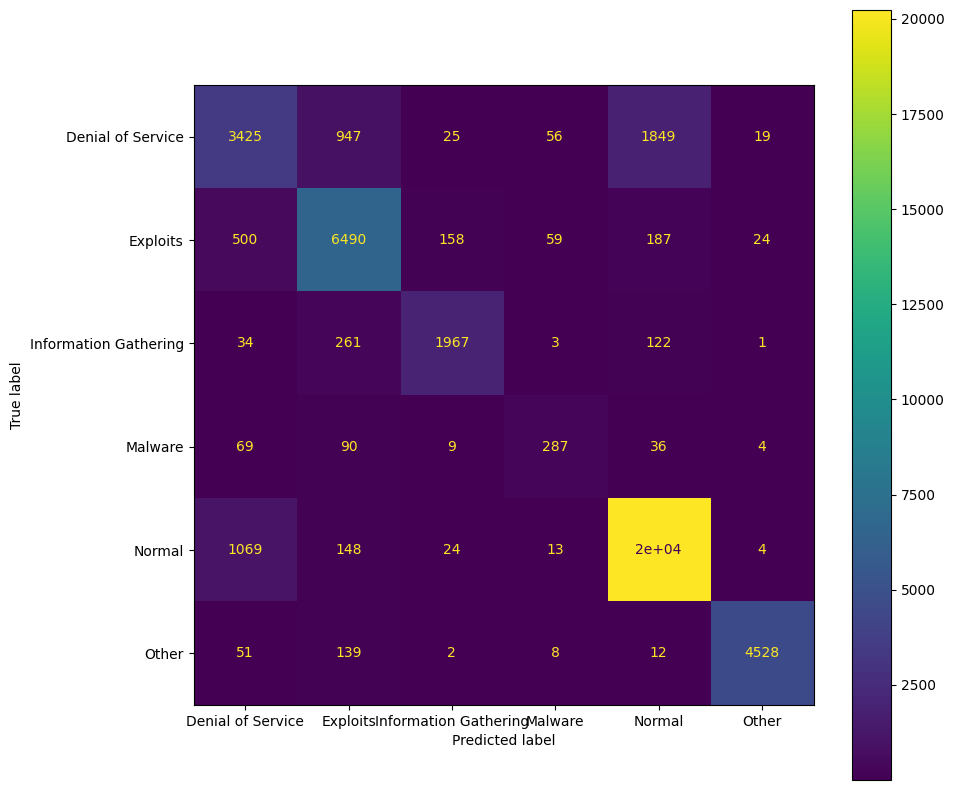

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,10))
disp.plot(ax=ax)

In [127]:
gmodel = LGBMClassifier(**models[0].get_params())
gmodel.fit(new_df[FEATURES], df[TARGET],
           eval_set=[(new_df[FEATURES],df[TARGET])],
           eval_metric=["logloss"],
           categorical_feature=categorical,
           verbose=50)

with open(f'../checkpoints/phase-2/prob-2/v1.pkl','wb') as file:
    pickle.dump(gmodel, file)

[LightGBM] [Warning] Unknown parameter: min_data_leaf
[50]	valid_0's multi_logloss: 0.280028
[100]	valid_0's multi_logloss: 0.228986


In [65]:
gmodel.feature_name_

['feature1',
 'feature2',
 'feature3',
 'feature4',
 'feature5',
 'feature6',
 'feature7',
 'feature8',
 'feature9',
 'feature10',
 'feature11',
 'feature12',
 'feature13',
 'feature14',
 'feature15',
 'feature16',
 'feature17',
 'feature18',
 'feature19',
 'feature20',
 'feature21',
 'feature23',
 'feature24',
 'feature25',
 'feature26',
 'feature27',
 'feature28',
 'feature29',
 'feature30',
 'feature31',
 'feature32',
 'feature33',
 'feature34',
 'feature35',
 'feature36',
 'feature38',
 'feature39',
 'feature40',
 'feature41',
 '9_10',
 '7+26']

In [16]:
len(processor.FEATURES)

41